In [1]:
import os
import pickle
import random
from functools import partial
import pandas as pd
import anonlink
from clkhash.field_formats import *
from clkhash.comparators import NgramComparison
from clkhash import Schema
from matplotlib import pyplot as plt

from clk_based_comparison import generate_clks, pr_curve_from_clks
from token_based_utils import tokenize_entities, sim_fun
from eval_utils import compute_accuracies, load_true_matches
from analysis import get_aucs

In [2]:
DATA_DIR = 'data'
MAX_SPARSENESS = 80  # up to 80% missing data
SPARSENESS_STEP = 5  # in 5% steps

# Exploration of how Anonlink handles missing data

Anonlink uses CLKs for entity resolution.

Although CLKs have been shown to work well for linkage on real world data, little work has been done to evaluate their resilience to missing data.

A CLK is a composite Bloom filter, that is that for an entity record, all feature values are tokenized and then inserted into one Bloom filter in such a way that the similarity of two filters relates to the similarity of the corresponding entity records.

The approach of combining all entity information into one representation can lead to problems when the entity information is incomplete. Consider the following scenario: 

```
Dataset A: John | Doe | First Street | 24 |      |             | 0404123456 
Dataset B: John | Doe |              | 24 | 1234 | Sunny Hills |
```
Those two records have three out of the seven features in common. This means that the corresponding composite Bloom filters each contain information from two features which is missing in the other filter. Thus, the comparison will procude a reduced similarity score.

This raises an interesting question. Will the reduction in similarity scores have an impact on the linkage results? And if so, what is the relationship between data sparseness and linkage quality?\
We will try to answer those question with some experimentation.

### data creation
We use the febrl tool to generate PII data. We create two pairs of base datasets, one where the entity records in the second dataset are identical to the first, if present, and in the second pair we introduce typical noise (like spelling mistakes).

For both pairs of base datasets we then create a series of datasets where we control the sparseness. In 5% increments, we remove datapoints from both datasets, up to 80% missing data.

In [14]:
def sparsify_df(df, percentage, seed=None):
    """removes 'percentage' percent elements from dataframe 'df' """
    rows = df.shape[0]
    cols = df.shape[1]
    num_elements = rows * cols
    num_to_remove = int(round(num_elements * percentage))
    if seed is not None:
        random.seed(seed)
    rem = random.sample(range(num_elements), num_to_remove)
    for i in rem:
        row = i // cols
        col = i % cols
        df.iloc[row, col] = ''

def load_datasets():
    dfa = pd.read_csv(os.path.join(DATA_DIR, 'PII_A.csv'), index_col=0, skipinitialspace=True)
    dfb_clean = pd.read_csv(os.path.join(DATA_DIR, 'PII_B_clean.csv'), index_col=0, skipinitialspace=True)
    dfb_noisy = pd.read_csv(os.path.join(DATA_DIR, 'PII_B_noisy.csv'), index_col=0, skipinitialspace=True)
    return dfa, dfb_clean, dfb_noisy

def create_base_datasets():
    dfa, dfb_clean, dfb_noisy = load_datasets()
    noisy_path = os.path.join(DATA_DIR, 'noisy')
    noisefree_path = os.path.join(DATA_DIR, 'noisefree')
    os.makedirs(noisefree_path, exist_ok=True)
    os.makedirs(noisy_path, exist_ok=True)
    dfa.to_csv(os.path.join(noisy_path, '00_A.csv'))
    dfb_noisy.to_csv(os.path.join(noisy_path, '00_B.csv'))
    dfa.to_csv(os.path.join(noisefree_path, '00_A.csv'))
    dfb_clean.to_csv(os.path.join(noisefree_path, '00_B.csv'))
    
    for sparsity in range(SPARSENESS_STEP, MAX_SPARSENESS+1, SPARSENESS_STEP):
        print(f'creating datasets with {sparsity}% missing data...')
        dfa, dfb_clean, dfb_noisy = load_datasets()
        sparsify_df(dfa, sparsity/100)
        dfa.to_csv(os.path.join(noisy_path, f'{sparsity:02}_A.csv'))
        dfa.to_csv(os.path.join(noisefree_path, f'{sparsity:02}_A.csv'))
        sparsify_df(dfb_noisy, sparsity / 100)
        dfb_noisy.to_csv(os.path.join(noisy_path, f'{sparsity:02}_B.csv'))
        sparsify_df(dfb_clean, sparsity/100)
        dfb_clean.to_csv(os.path.join(noisefree_path, f'{sparsity:02}_B.csv'))

In [15]:
create_base_datasets()

creating datasets with 5% missing data...
creating datasets with 10% missing data...
creating datasets with 15% missing data...
creating datasets with 20% missing data...
creating datasets with 25% missing data...
creating datasets with 30% missing data...
creating datasets with 35% missing data...
creating datasets with 40% missing data...
creating datasets with 45% missing data...
creating datasets with 50% missing data...
creating datasets with 55% missing data...
creating datasets with 60% missing data...
creating datasets with 65% missing data...
creating datasets with 70% missing data...
creating datasets with 75% missing data...
creating datasets with 80% missing data...


## Linkage schema
Clkhash support two different strategies to insert tokens into the Bloom filter:

- BitsPerTokenStrategy: Insert every token *bitsPerToken* number of times.

- BitsPerFeatureStrategy: Same number of insertions for each value of this feature, irrespective of the actual number of tokens. The number of filter insertions for a token is computed by dividing bitsPerFeature equally amongst the tokens.

We will create CLKs for both strategies. 

In [3]:
clk_length = 1024

fields = [
    Ignore('id'),
    StringSpec('given_name', FieldHashingProperties(comparator=NgramComparison(2), 
                                                    strategy=BitsPerTokenStrategy(8), 
                                                    missing_value=MissingValueSpec(sentinel=''))),
    StringSpec('surname', FieldHashingProperties(comparator=NgramComparison(2), 
                                                 strategy=BitsPerTokenStrategy(8),
                                                 missing_value=MissingValueSpec(sentinel=''))),
    IntegerSpec('street_number', FieldHashingProperties(comparator=NgramComparison(1, positional=True), 
                                                        strategy=BitsPerTokenStrategy(8), 
                                                        missing_value=MissingValueSpec(sentinel=''))),
    StringSpec('address_1', FieldHashingProperties(comparator=NgramComparison(2), 
                                                   strategy=BitsPerTokenStrategy(8), 
                                                   missing_value=MissingValueSpec(sentinel=''))),
    StringSpec('address_2', FieldHashingProperties(comparator=NgramComparison(2), 
                                                   strategy=BitsPerTokenStrategy(8), 
                                                   missing_value=MissingValueSpec(sentinel=''))),
    StringSpec('suburb', FieldHashingProperties(comparator=NgramComparison(2), 
                                                strategy=BitsPerTokenStrategy(8), 
                                                missing_value=MissingValueSpec(sentinel=''))),
    IntegerSpec('postcode', FieldHashingProperties(comparator=NgramComparison(1, positional=True), 
                                                   strategy=BitsPerTokenStrategy(8), 
                                                   missing_value=MissingValueSpec(sentinel=''))),
    StringSpec('state', FieldHashingProperties(comparator=NgramComparison(2), 
                                               strategy=BitsPerTokenStrategy(8), 
                                               missing_value=MissingValueSpec(sentinel=''))),
    IntegerSpec('date_of_birth', FieldHashingProperties(comparator=NgramComparison(1, positional=True), 
                                                        strategy=BitsPerTokenStrategy(8), 
                                                        missing_value=MissingValueSpec(sentinel=''))),
    StringSpec('phone_number', FieldHashingProperties(comparator=NgramComparison(1, positional=True), 
                                                      strategy=BitsPerTokenStrategy(8), 
                                                      missing_value=MissingValueSpec(sentinel=''))),
    IntegerSpec('soc_sec_id', FieldHashingProperties(comparator=NgramComparison(1, positional=True), 
                                                     strategy=BitsPerTokenStrategy(8), 
                                                     missing_value=MissingValueSpec(sentinel='')))
]

fixed_k_schema = Schema(fields, clk_length)

fields = [
    Ignore('id'),
    StringSpec('given_name', FieldHashingProperties(comparator=NgramComparison(2), 
                                                    strategy=BitsPerFeatureStrategy(60), 
                                                    missing_value=MissingValueSpec(sentinel=''))),
    StringSpec('surname', FieldHashingProperties(comparator=NgramComparison(2), 
                                                 strategy=BitsPerFeatureStrategy(60), 
                                                 missing_value=MissingValueSpec(sentinel=''))),
    IntegerSpec('street_number', FieldHashingProperties(comparator=NgramComparison(1, positional=True), 
                                                        strategy=BitsPerFeatureStrategy(60),  
                                                        missing_value=MissingValueSpec(sentinel=''))),
    StringSpec('address_1', FieldHashingProperties(comparator=NgramComparison(2), 
                                                   strategy=BitsPerFeatureStrategy(60),  
                                                   missing_value=MissingValueSpec(sentinel=''))),
    StringSpec('address_2', FieldHashingProperties(comparator=NgramComparison(2), 
                                                   strategy=BitsPerFeatureStrategy(60), 
                                                   missing_value=MissingValueSpec(sentinel=''))),
    StringSpec('suburb', FieldHashingProperties(comparator=NgramComparison(2), 
                                                strategy=BitsPerFeatureStrategy(60), 
                                                missing_value=MissingValueSpec(sentinel=''))),
    IntegerSpec('postcode', FieldHashingProperties(comparator=NgramComparison(1, positional=True), 
                                                   strategy=BitsPerFeatureStrategy(60), 
                                                   missing_value=MissingValueSpec(sentinel=''))),
    StringSpec('state', FieldHashingProperties(comparator=NgramComparison(2), 
                                               strategy=BitsPerFeatureStrategy(60), 
                                               missing_value=MissingValueSpec(sentinel=''))),
    IntegerSpec('date_of_birth', FieldHashingProperties(comparator=NgramComparison(1, positional=True), 
                                                        strategy=BitsPerFeatureStrategy(60), 
                                                        missing_value=MissingValueSpec(sentinel=''))),
    StringSpec('phone_number', FieldHashingProperties(comparator=NgramComparison(1, positional=True), 
                                                      strategy=BitsPerFeatureStrategy(60), 
                                                      missing_value=MissingValueSpec(sentinel=''))),
    IntegerSpec('soc_sec_id', FieldHashingProperties(comparator=NgramComparison(1, positional=True), 
                                                     strategy=BitsPerFeatureStrategy(60), 
                                                     missing_value=MissingValueSpec(sentinel='')))
]

var_k_schema = Schema(fields, clk_length)

## Baseline
We will compare clkhash against three different baselines:

### per feature based comparison baselines
We compare records on a per feature basis, that is, we compare two records by comparing the values for each feature 
separately and then combine those feature similarities in a meaningful way. 
This gives us a chance to treat the feature values that are missing differently to the present values.

#### a) sum of similarities
This is a simple way of combining the feature similarity. We just sum them up. The higher the sum, the more likely it is a match.

#### b) averaged token comparison per feature
We compute the similarity for each pair of feature values and set the similarity to zero if one of the values is missing. The similarity score is computed as the average of the non-zero similarity values. Finally, to favour scores with more non-zero similarity values, we introduce a penalty factor which increases with the number of features with missing data. (The choice of 0.95 is arbitrary, but experiments with different factors achieved very similar results.)

![image.png](image.png)

### comparisons of tokens of all features (composite)
This is closer to CLKs. Here we produce all the tokens of a record combine them in a set. We then compute the similarity of the sets. So no detour to Bloom filters. 
This is interesting, as it is an upper bound of what composite Bloom filter based matching can achieve. 

In [8]:
def token_based_comparison(file_a, file_b, schema, true_matches):
    print('tokenize entities...')
    tok_a = tokenize_entities(file_a, schema)
    tok_b = tokenize_entities(file_b, schema)
    print('done')

    folder, filename = os.path.split(file_a)
    for per_feature, sum_of_sims in ((True, False), (True, True), (False, False)):
        print(f'generate candidate pairs with per_feature={per_feature} and sum_of_sims={sum_of_sims} ...')
        result = anonlink.candidate_generation.find_candidate_pairs(
            (tok_a, tok_b),
            partial(sim_fun, per_feature, sum_of_sims),
            0.0)
        print('solve...')
        precisions, recalls = compute_accuracies(result, true_matches)
        file_ex = "per_feature" if per_feature else "composite"
        if sum_of_sims:
            file_ex = file_ex + '_sum_of_sims'
        with open(os.path.join(folder, f'{filename[0:2]}_pr_{file_ex}.pkl'), 'wb') as f:
            pickle.dump((precisions, recalls), f)

the_truth = load_true_matches(os.path.join(DATA_DIR, 'PII_A.csv'), os.path.join(DATA_DIR, 'PII_B_clean.csv'))
for folder in ('noisefree', 'noisy'):
    for percentage in range(0, MAX_SPARSENESS+1, SPARSENESS_STEP):
        print(f'currently working on {folder} with {percentage}% missing values')
        token_based_comparison(os.path.join(DATA_DIR, folder, f'{percentage:02}_A.csv'), 
                               os.path.join(DATA_DIR, folder, f'{percentage:02}_B.csv'), var_k_schema, the_truth)
print('done')

currently working on noisefree with 0% missing values
tokenize entities...
done
generate candidate pairs with per_feature=True and sum_of_sims=False ...
solve...
generate candidate pairs with per_feature=True and sum_of_sims=True ...
solve...
generate candidate pairs with per_feature=False and sum_of_sims=False ...
solve...
currently working on noisefree with 5% missing values
tokenize entities...
done
generate candidate pairs with per_feature=True and sum_of_sims=False ...
solve...
generate candidate pairs with per_feature=True and sum_of_sims=True ...
solve...
generate candidate pairs with per_feature=False and sum_of_sims=False ...
solve...
currently working on noisefree with 10% missing values
tokenize entities...
done
generate candidate pairs with per_feature=True and sum_of_sims=False ...
solve...
generate candidate pairs with per_feature=True and sum_of_sims=True ...
solve...
generate candidate pairs with per_feature=False and sum_of_sims=False ...
solve...
currently working on 

done
generate candidate pairs with per_feature=True and sum_of_sims=False ...
solve...
generate candidate pairs with per_feature=True and sum_of_sims=True ...
solve...
generate candidate pairs with per_feature=False and sum_of_sims=False ...
solve...
currently working on noisy with 45% missing values
tokenize entities...
done
generate candidate pairs with per_feature=True and sum_of_sims=False ...
solve...
generate candidate pairs with per_feature=True and sum_of_sims=True ...
solve...
generate candidate pairs with per_feature=False and sum_of_sims=False ...
solve...
currently working on noisy with 50% missing values
tokenize entities...
done
generate candidate pairs with per_feature=True and sum_of_sims=False ...
solve...
generate candidate pairs with per_feature=True and sum_of_sims=True ...
solve...
generate candidate pairs with per_feature=False and sum_of_sims=False ...
solve...
currently working on noisy with 55% missing values
tokenize entities...
done
generate candidate pairs w

### Quality metric

We measure the quality of the linkage as the area under the precision-recall curve. A precision-recall curve is very similar to ROC, the only difference is that it does not take the true negatives into account. This is very useful in our case, as we have an imbalanced problem (the number of non-matches outweighs the number of matches by orders of magnitude), and ROC would show skewed results. Precision-recall curves are not affected by the class imbalance.

The area under the precision-recall curve has a value between 0 and 1, the higher, the better.

Let's first look at the results for the baselines.

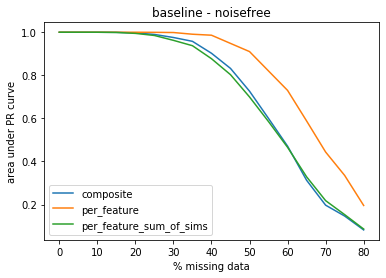

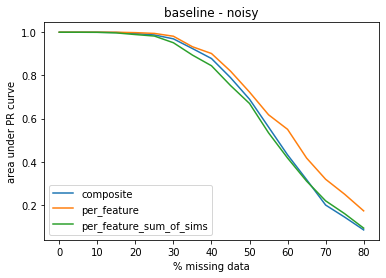

In [9]:
def print_pr_curve(folder, strategies, title):
    x = range(0, MAX_SPARSENESS+1, SPARSENESS_STEP)
    aucs = get_aucs(folder, strategies)
    for k, v in aucs.items():
        plt.plot(x, v, label=k)
    plt.title(title)
    plt.legend()
    plt.xlabel('% missing data')
    plt.ylabel('area under PR curve')
    plt.show()

print_pr_curve(os.path.join(DATA_DIR, 'noisefree'), ('composite', 'per_feature', 'per_feature_sum_of_sims'), 'baseline - noisefree')
print_pr_curve(os.path.join(DATA_DIR, 'noisy'), ('composite', 'per_feature', 'per_feature_sum_of_sims'), 'baseline - noisy')

We can see that it is advantegeous to compare the feature values separately, it produces better results for the same amount of missing data compared to the composite aproach. Surprisingly, the *composite* comparison is more resilient to noise in the data than the *per_feature* comparison as its performance is largly unaffected. The *per_feature* approach looses almost all of its advantage and the results are very similar.

Let's produce the CLKs for both strategies and evaluate the linkage results over all the different datasets.

In [25]:
schema_dict = {'bits_per_token': fixed_k_schema,
               'bits_per_feature': var_k_schema}

def run_series(folder, schema_dict, true_matches):
    for label, schema in schema_dict.items():
        print(f'current schema: {label}')
        for i in range(0, MAX_SPARSENESS+1, SPARSENESS_STEP):
            print(f'working on {i}% missing values')
            ds1 = os.path.join(folder, f'{i:02}_A.csv')
            ds2 = os.path.join(folder, f'{i:02}_B.csv')
            clks_a = generate_clks(ds1, schema)
            clks_b = generate_clks(ds2, schema)
            precisions, recalls = pr_curve_from_clks(clks_a, clks_b, 0, true_matches)
            res_file = os.path.join(folder, f'{i:02}_pr_{label}.pkl')
            with open(res_file, 'wb') as f:
                pickle.dump((precisions, recalls), f)
            print('done')

true_matches = load_true_matches(os.path.join(DATA_DIR, 'PII_A.csv'), os.path.join(DATA_DIR,'PII_B_clean.csv'))
for folder in (os.path.join(DATA_DIR, 'noisy'), os.path.join(DATA_DIR, 'noisefree')):
    print(f'working on folder: {folder}')
    run_series(folder, schema_dict, true_matches)

generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

working on folder: data2/noisy
current schema: bits_per_token
working on 0% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 2.52kclk/s, mean=509, std=27.3]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 2.61kclk/s, mean=508, std=27.9]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 5% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 2.66kclk/s, mean=490, std=38.9]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 2.76kclk/s, mean=489, std=39.3]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 10% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 2.07kclk/s, mean=472, std=46.8]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 2.59kclk/s, mean=471, std=49.5]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 15% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 2.90kclk/s, mean=450, std=55.6]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 2.93kclk/s, mean=450, std=55.8]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 20% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 2.94kclk/s, mean=431, std=60.6]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 2.84kclk/s, mean=430, std=62.1]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 25% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 2.95kclk/s, mean=410, std=68.1]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.24kclk/s, mean=409, std=67.3]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 30% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.25kclk/s, mean=388, std=74.1]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.44kclk/s, mean=386, std=75]  
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 35% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.13kclk/s, mean=366, std=78.2]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.89kclk/s, mean=363, std=80.3]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 40% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.72kclk/s, mean=342, std=81.8]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.57kclk/s, mean=343, std=79.7]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 45% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.95kclk/s, mean=318, std=85]  
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.95kclk/s, mean=315, std=86.8]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 50% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.33kclk/s, mean=295, std=87.7]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.23kclk/s, mean=293, std=89.6]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 55% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.64kclk/s, mean=268, std=91.1]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.66kclk/s, mean=268, std=87.4]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 60% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.33kclk/s, mean=242, std=90.7]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.99kclk/s, mean=242, std=90.6]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 65% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 6.58kclk/s, mean=214, std=91.2]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 6.92kclk/s, mean=215, std=91.3]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 70% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 7.27kclk/s, mean=187, std=89.4]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 7.75kclk/s, mean=185, std=88.4]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 75% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 8.15kclk/s, mean=159, std=85.8]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 8.47kclk/s, mean=159, std=89.7]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 80% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 10.3kclk/s, mean=127, std=80.9]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 10.7kclk/s, mean=128, std=82.2]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
current schema: bits_per_feature
working on 0% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.32kclk/s, mean=484, std=8.7] 
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.25kclk/s, mean=484, std=8.79]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 5% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.43kclk/s, mean=466, std=25.6]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.26kclk/s, mean=466, std=26.1]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 10% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.58kclk/s, mean=447, std=34.2]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.47kclk/s, mean=447, std=36.1]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 15% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.73kclk/s, mean=428, std=42.5]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.38kclk/s, mean=428, std=42.7]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 20% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.96kclk/s, mean=409, std=47.1]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.82kclk/s, mean=408, std=49]  
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 25% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.29kclk/s, mean=388, std=53]  
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.11kclk/s, mean=388, std=54.2]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 30% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.48kclk/s, mean=367, std=60]  
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.33kclk/s, mean=367, std=60.7]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 35% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.78kclk/s, mean=345, std=63.1]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.64kclk/s, mean=345, std=65.3]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 40% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.87kclk/s, mean=323, std=66]  
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.28kclk/s, mean=323, std=66.5]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 45% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.35kclk/s, mean=301, std=70]  
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.08kclk/s, mean=300, std=72.5]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 50% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.74kclk/s, mean=277, std=71.6]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.37kclk/s, mean=277, std=73.7]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 55% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 6.11kclk/s, mean=253, std=74.6]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.99kclk/s, mean=253, std=70.9]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 60% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 6.72kclk/s, mean=228, std=75.2]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 6.44kclk/s, mean=228, std=73.5]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 65% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 7.48kclk/s, mean=202, std=75.1]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 7.16kclk/s, mean=202, std=75.8]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 70% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 8.19kclk/s, mean=175, std=74.9]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 8.02kclk/s, mean=175, std=75.5]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 75% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 8.86kclk/s, mean=148, std=71.5]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 9.19kclk/s, mean=148, std=75]  
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 80% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 10.4kclk/s, mean=120, std=66.8]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 10.7kclk/s, mean=120, std=69.1]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on folder: data2/noisefree
current schema: bits_per_token
working on 0% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.26kclk/s, mean=509, std=27.3]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.22kclk/s, mean=508, std=27.9]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 5% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.33kclk/s, mean=490, std=38.9]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.39kclk/s, mean=490, std=39]  
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 10% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.59kclk/s, mean=472, std=46.8]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.48kclk/s, mean=471, std=48.8]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 15% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.79kclk/s, mean=450, std=55.6]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.61kclk/s, mean=451, std=56.7]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 20% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.01kclk/s, mean=431, std=60.6]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.84kclk/s, mean=430, std=62.6]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 25% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.26kclk/s, mean=410, std=68.1]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.06kclk/s, mean=409, std=67.9]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 30% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.96kclk/s, mean=388, std=74.1]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.31kclk/s, mean=389, std=74.7]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 35% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.68kclk/s, mean=366, std=78.2]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.49kclk/s, mean=365, std=75.4]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 40% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.17kclk/s, mean=342, std=81.8]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.92kclk/s, mean=341, std=83.2]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 45% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.36kclk/s, mean=318, std=85]  
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.16kclk/s, mean=318, std=81.8]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 50% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.53kclk/s, mean=295, std=87.7]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.47kclk/s, mean=293, std=88.2]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 55% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 6.03kclk/s, mean=268, std=91.1]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.88kclk/s, mean=269, std=88.1]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 60% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 6.64kclk/s, mean=242, std=90.7]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 6.36kclk/s, mean=241, std=89.2]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 65% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 7.30kclk/s, mean=214, std=91.2]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 7.07kclk/s, mean=215, std=91.6]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 70% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 8.07kclk/s, mean=187, std=89.4]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 8.09kclk/s, mean=188, std=89.8]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 75% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 8.67kclk/s, mean=159, std=85.8]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 9.38kclk/s, mean=157, std=86.1]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 80% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 9.54kclk/s, mean=127, std=80.9]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 9.93kclk/s, mean=127, std=83.5]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
current schema: bits_per_feature
working on 0% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.25kclk/s, mean=484, std=8.7] 
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.21kclk/s, mean=483, std=8.63]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 5% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.37kclk/s, mean=466, std=25.6]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.37kclk/s, mean=466, std=25.5]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 10% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.57kclk/s, mean=447, std=34.2]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.51kclk/s, mean=447, std=35.4]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 15% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 2.62kclk/s, mean=428, std=42.5]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.64kclk/s, mean=428, std=43.3]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 20% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.98kclk/s, mean=409, std=47.1]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 3.84kclk/s, mean=408, std=49.7]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 25% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.16kclk/s, mean=388, std=53]  
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.07kclk/s, mean=388, std=54]  
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 30% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.34kclk/s, mean=367, std=60]  
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.37kclk/s, mean=367, std=60]  
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 35% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.54kclk/s, mean=345, std=63.1]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.51kclk/s, mean=346, std=62]  
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 40% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.00kclk/s, mean=323, std=66]  
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 4.81kclk/s, mean=323, std=67.4]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 45% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.32kclk/s, mean=301, std=70]  
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.19kclk/s, mean=300, std=69]  
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 50% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.68kclk/s, mean=277, std=71.6]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.48kclk/s, mean=277, std=71.4]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 55% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.92kclk/s, mean=253, std=74.6]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 5.91kclk/s, mean=253, std=73.8]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 60% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 6.47kclk/s, mean=228, std=75.2]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 6.27kclk/s, mean=228, std=74.2]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 65% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 7.31kclk/s, mean=202, std=75.1]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 7.01kclk/s, mean=202, std=75.4]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 70% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 7.87kclk/s, mean=175, std=74.9]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 8.13kclk/s, mean=175, std=75.5]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 75% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 8.77kclk/s, mean=148, std=71.5]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 9.15kclk/s, mean=148, std=72.3]
generating CLKs:   0%|          | 0.00/2.00k [00:00<?, ?clk/s, mean=0, std=0]

done
working on 80% missing values


generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 10.1kclk/s, mean=120, std=66.8]
generating CLKs: 100%|██████████| 2.00k/2.00k [00:00<00:00, 10.6kclk/s, mean=120, std=69.5]


done


### Results
It's time to compare the linkage quality of the CLKs to the two baselines from before. For both, the noisefree and the noisy dataset we create a graph where we compare 
the two baselines:
- 'per_feature' - averaged feature-wise token comparison
- 'composite' - comparison of the combined tokens of all features

to the two CLK encoding strategies:
- 'bits_per_token' - Insert every token bitsPerToken number of times.
- 'bits_per_feature'- Same number of insertions for each value of this feature.


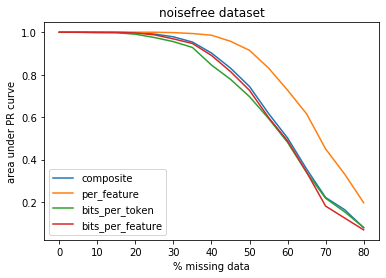

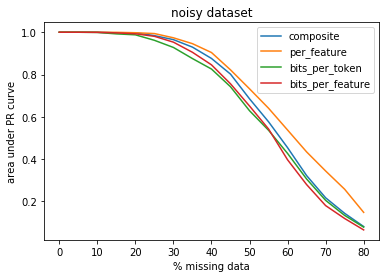

In [27]:
print_pr_curve(os.path.join(DATA_DIR, 'noisefree'), ('composite', 'per_feature', 'bits_per_token', 'bits_per_feature'), 'noisefree dataset')
print_pr_curve(os.path.join(DATA_DIR, 'noisy'), ('composite', 'per_feature', 'bits_per_token', 'bits_per_feature'), 'noisy dataset')

### Conclusions
The CLK-based linkage results are very close to the ones from the *composite* comparison technique (that's the comparison of the sets of tokens of the records).

Interestingly, the *bits_per_feature* strategy performs slightly better than the *bits_per_token* strategy for data sparseness of up to 55%. This is somewhat surprising, as the *bits_per_token* strategy more closely resembles the *composite* comparison technique.

The ability to compare feature values separately enables better comparison results for the same level of data sparseness. In the noisefree case, the *per_feature* comparison produces similar results to the composite techiques for data with up to 15% less data points. However, this advantage almost disappears once noise is added to the dataset.

For this dataset, anonlink can handle up to 20% missing data without any degredation in linkage quality. The quality will decrease sharply for data sparseness over 30%.